## Digital Image Processing, ECE419

Ernesto Colon

The Cooper Union Department of Electrical Engineering


February 2nd, 2021

References:
- Digital Image Processing Using Matlab [DIPUM] by Gonzalez et al., 3rd ed
- Digital Image Processing by Gonzalez et al., 4th ed

**The following set of notes and example scripts are part of my independent study sessions and adapted from the references outlined above. My main reference is DIPUM and complemented with online documentation. As I go through the theory and textbook examples, I am translating the code and image processing techniques to Python.**

## Frequency Domain Filtering Notes/Exercises/Sandbox

In [1]:
#Importing the libraries
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import ec_img_utils
import skimage.util
from skimage import io
import scipy.fft

**Computing and visualizing the 2-D Fourier Transform**

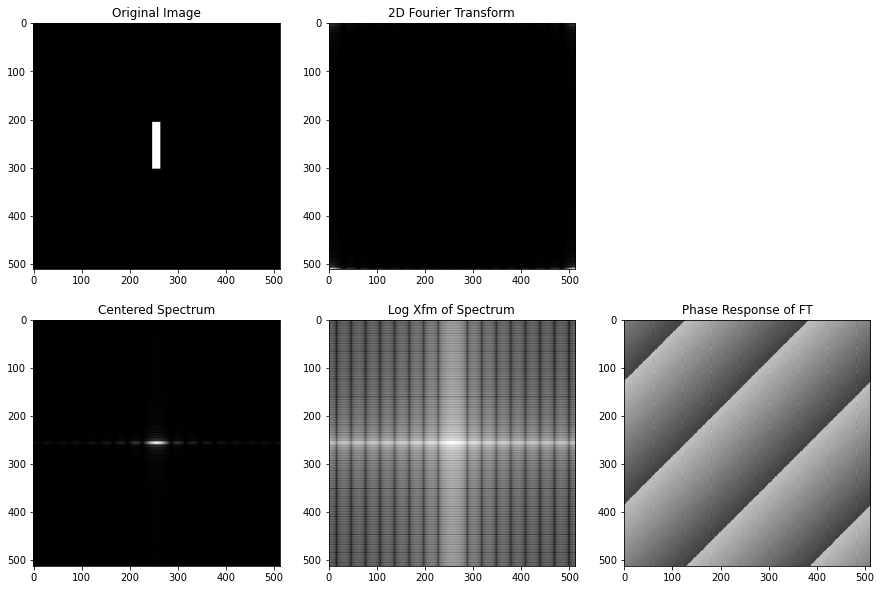

In [2]:
#import vertical bar image
img_vert_bar = io.imread('./images/vertical-bar.tif')

#display the original image
fig_vert_bar, ax_vert_bar = plt.subplots(2,3,figsize = (15,10))
ax_vert_bar = ax_vert_bar.ravel()

ax_vert_bar[0].imshow(img_vert_bar, cmap = 'gray'); ax_vert_bar[0].set_title('Original Image');

#Compute the 2D Fourier Transform
ft_vert_bar = scipy.fft.fft2(img_vert_bar)

#compute the spectrum 
spec_vert_bar = np.abs(ft_vert_bar)

#display the computed 2D FT
ax_vert_bar[1].imshow(skimage.img_as_float(spec_vert_bar), cmap = 'gray'); ax_vert_bar[1].set_title('2D Fourier Transform');

#Because of the periodic nature of the Discrete Fourier Transform, we get the four bright spots in the corners. Let's shift/center the spectrum
ft_ctr_vert_bar = scipy.fft.fftshift(ft_vert_bar)
spec_ctr_vert_bar = np.abs(ft_ctr_vert_bar)

#display shifted spectrum
ax_vert_bar[3].imshow(spec_ctr_vert_bar,cmap = 'gray'); ax_vert_bar[3].set_title('Centered Spectrum');

#As discussed in Chapter 3, the dynamic range of the Fourier Transform can be extremely large. Applying a log transformation to our image improves our ability to visualize the spectrum
spec_log_vert = ec_img_utils.log_xfm(spec_ctr_vert_bar, {})
ax_vert_bar[4].imshow(spec_log_vert, cmap = 'gray'); ax_vert_bar[4].set_title('Log Xfm of Spectrum');

#Compute the phase response of our 2D Fourier Transform. We use arctan2() from numpy to compute the four-quadrant arctangent
phs_vert_bar = np.arctan2(np.real(ft_vert_bar), np.imag(ft_vert_bar))
ax_vert_bar[5].imshow(phs_vert_bar, cmap = 'gray'); ax_vert_bar[5].set_title('Phase Response of FT');

fig_vert_bar.delaxes(ax_vert_bar[2])

### Filtering in the Frequency Domain

**Example 4.1 from DIPUM - Effects of filtering with and without padding**

Image Information

 | Shape      | Data type   |   Bytes |   Range |
|------------|-------------|---------|---------|
| (600, 600) | uint8       |  360000 |       0 |
|            |             |         |     255 |

Padded FFT size is:  (1200, 1200)

Gaussian LPF transfer function for padded FFT has size:  (1200, 1200) 



Text(0.5, 1.0, 'LPF with padding')

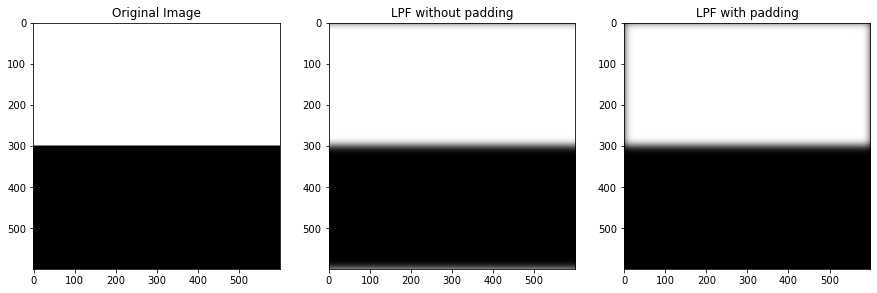

In [3]:
#first filter in the frequency domain without padding

#load two stripes image
img_two_strp = io.imread('./images/two-stripes.tif')

#print image information
ec_img_utils.get_img_info(img_two_strp)

#display the image
fig_tw_strp, ax_two_strp = plt.subplots(1,3, figsize = (15,5))

ax_two_strp = ax_two_strp.ravel()

ax_two_strp[0].imshow(img_two_strp, cmap = 'gray'); ax_two_strp[0].set_title('Original Image');

#Compute the 2D FT of the image
M,N = img_two_strp.shape
ft_two_strp = scipy.fft.fft2(img_two_strp)
gauss_sig = 10
lpf_gauss_H1 = ec_img_utils.lp_gaussian(M,N,gauss_sig)

filt_two_strp = lpf_gauss_H1 * ft_two_strp

#compute inverse FT
ift_two_strp = scipy.fft.ifft2(filt_two_strp)

#display image
ax_two_strp[1].imshow(np.real(ift_two_strp), cmap = 'gray');
ax_two_strp[1].set_title('LPF without padding')

#note the presence of black borders in the filtered image due to the periodic nature of the FT

#filtering with padding now

#get padded dimensions using utility function padded_size - adapted from DIPUM
padded_dim = ec_img_utils.padded_size({'img_dim':img_two_strp.shape})

#compute the FFT with zero padding
ft_two_strp_padded = scipy.fft.fft2(img_two_strp, s = padded_dim)

#confirm that the FFT size
print("\nPadded FFT size is: ", ft_two_strp_padded.shape)

#Get Gaussian LPF transfer function
lpf_gauss_H2 = ec_img_utils.lp_gaussian(padded_dim[0],padded_dim[1],2*gauss_sig)

#confirm Guassian LPF transfer function has the right size
print("\nGaussian LPF transfer function for padded FFT has size: ", lpf_gauss_H2.shape,"\n")

#Frequency domain filtering
filt_two_strp_padded = ft_two_strp_padded * lpf_gauss_H2

#compute inverse FT
ift_two_strp_padded = scipy.fft.ifft2(filt_two_strp_padded)

#Crop image back to the original size
ift_two_strp_padded = ift_two_strp_padded[0:img_two_strp.shape[0], 0:img_two_strp.shape[1]]

#display image
ax_two_strp[2].imshow(np.real(ift_two_strp_padded), cmap = 'gray');
ax_two_strp[2].set_title('LPF with padding')

Note that the image without padding only has a black border along the top and bottom edge, not in the vertical directions. This is due to the periodic nature of the 2D FT. On the other hand, when we padded the image with zeros prior to computing the FFT, we see that we now have a uniform grayish border. Of course, this is not desirable in some cases, like the example above. The key point is that we can compute a power of two padded dimension and then use other padding methods (e.g., symmetric warp, extensions, etc.) to process our images. 

### Lowpass (smoothing) frequency domain filter transfer functions

An ideal lowpass filter has the following transfer function:

\begin{array}{ll}
     H(u,v) =  1 & if ~~D(u,v) \leq D_0 \\
      H(u,v) = 0 & if ~~ D(u,v) > D_0 \\
\end{array}

Where $D_0$ is a positive number and $D(u,v)$ is the distance from point $(u,v)$ to the center of the transfer function.

Text(0.5, 1.0, 'Ideal LPF')

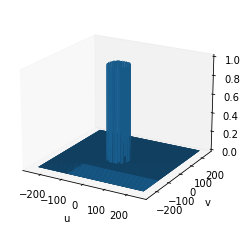

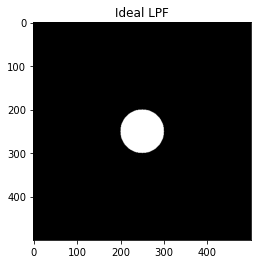

In [4]:
# Plotting the transfer function of LPF's
# Get meshgrid for plotting
U, V = ec_img_utils.dftuv(500,500)

# Ideal LPF filter
H_ideal = ec_img_utils.lp_filter('ideal', 500, 500, 50)

# shift spectrum
H_ideal_shft = scipy.fft.fftshift(H_ideal).astype(int)

fig_lpf_ideal = plt.figure()

ax_lpf_ideal = fig_lpf_ideal.add_subplot(1, 1, 1, projection = '3d')
ideal_surf = ax_lpf_ideal.plot_surface(U, V, H_ideal)
ax_lpf_ideal.set_xlabel('u')
ax_lpf_ideal.set_ylabel('v')
ax_lpf_ideal.view_init(20)
ax_lpf_ideal.grid(False)

# Display 2D ideal LPF as an image
fig_lpf_ideal2, ax_lpf_ideal2 = plt.subplots(1, 1)
ax_lpf_ideal2.imshow(H_ideal_shft, cmap = 'gray'); ax_lpf_ideal2.set_title('Ideal LPF')

From the 3D plot and ideal LPF imag shown above, we see that the ideal LPF essentially masks out any frequency components outside of its passband.

Next, we explore a Butterworth filter with a smoother transition relative to our 'brickwall' ideal LPF. A Butterworth filter has the following transfer function:

\begin{equation}
H(u,v) = \frac{1}{1 + ( \frac{D(u,v)}{D_0})^{2n})}
\end{equation}

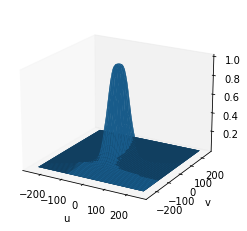

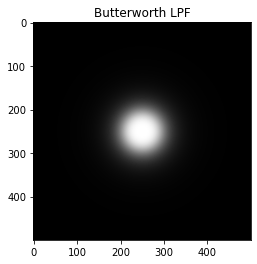

In [5]:
# Butterworth LPF filter
H_butterworth = ec_img_utils.lp_filter('butterworth', 500, 500, 50, 2)

# shift spectrum
H_butterworth_shft = scipy.fft.fftshift(H_butterworth)

fig_lpf_bttr = plt.figure()

ax_lpf_bttr = fig_lpf_bttr.add_subplot(1, 1, 1, projection = '3d')
bttr_surf = ax_lpf_bttr.plot_surface(U, V, H_butterworth)
ax_lpf_bttr.set_xlabel('u')
ax_lpf_bttr.set_ylabel('v')
ax_lpf_bttr.view_init(20)
ax_lpf_bttr.grid(False)

# Display 2D ideal LPF as an image
fig_lpf_bttr2, ax_lpf_bttr2 = plt.subplots(1, 1)
ax_lpf_bttr2.imshow(H_butterworth_shft, cmap = 'gray'); ax_lpf_bttr2.set_title('Butterworth LPF');

From the Butterworth image shown above, we see that the transition from passband to stopband is more gradual.

A Gaussian lowpass filter has the following form:

\begin{equation}
H(u,v) = e^{-D^2(u,v)/2\sigma^2}
\end{equation}

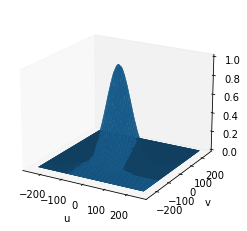

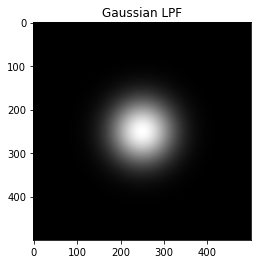

In [6]:
# Butterworth LPF filter
H_gauss = ec_img_utils.lp_filter('gaussian', 500, 500, 50)

# shift spectrum
H_gauss_shft = scipy.fft.fftshift(H_gauss)

fig_lpf_gauss = plt.figure()

ax_lpf_gauss = fig_lpf_gauss.add_subplot(1, 1, 1, projection = '3d')
gauss_surf = ax_lpf_gauss.plot_surface(U, V, H_gauss)
ax_lpf_gauss.set_xlabel('u')
ax_lpf_gauss.set_ylabel('v')
ax_lpf_gauss.view_init(20)
ax_lpf_gauss.grid(False)

# Display 2D ideal LPF as an image
fig_lpf_gauss2, ax_lpf_gauss2 = plt.subplots(1, 1)
ax_lpf_gauss2.imshow(H_gauss_shft, cmap = 'gray'); ax_lpf_gauss2.set_title('Gaussian LPF');

Note that the Gaussian filter has a wider transition than the Butterworth filter. However, we can control our Butterworth' filter stopband transition by controlling
the filter order.

**Example 4.4 from DIPUM - Lowpass filtering**

In [7]:
# Load test pattern image
img_tst_pttrn = io.imread('./images/testpattern512.tif')

# Compute padding dimensions
tst_pttrn_pad_dim = ec_img_utils.padded_size({"img_dim": img_tst_pttrn.shape})

#Ideal LPI
D0 = 50
tst_HLPI = ec_img_utils.lp_filter('ideal', tst_pttrn_pad_dim[0], tst_pttrn_pad_dim[1], D0)

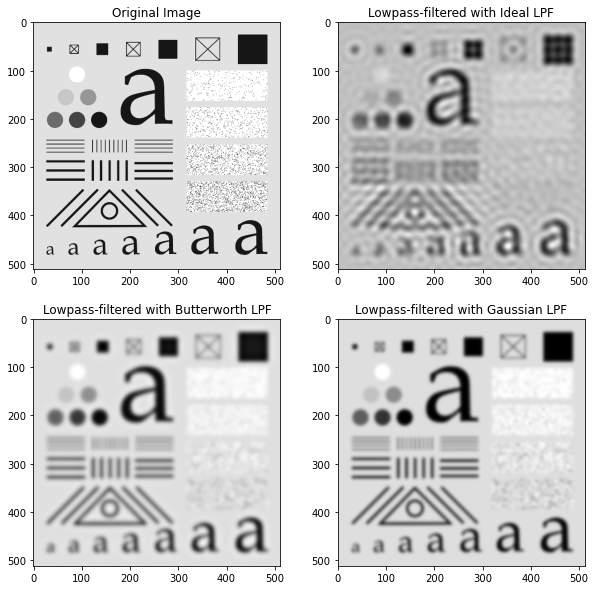

In [8]:
#filter the image
tst_LPI = ec_img_utils.dft_filt(img_tst_pttrn, tst_HLPI, 'symmetric')

#display filtered image
fig_tst_pttrn, ax_tst_pttrn = plt.subplots(2,2,figsize=(10,10))
ax_tst_pttrn = ax_tst_pttrn.ravel()

ax_tst_pttrn[0].imshow(img_tst_pttrn, cmap='gray')
ax_tst_pttrn[0].set_title("Original Image");

ax_tst_pttrn[1].imshow(tst_LPI, cmap='gray')
ax_tst_pttrn[1].set_title("Lowpass-filtered with Ideal LPF");

# Filter with Butterworth LPF
tst_LPBTTR = ec_img_utils.lp_filter('butterworth', tst_pttrn_pad_dim[0], tst_pttrn_pad_dim[1], D0, 2)

# Filter the image (Butterworth)
tst_lp_buttr = ec_img_utils.dft_filt(img_tst_pttrn, tst_LPBTTR, 'symmetric')

# Display the image
ax_tst_pttrn[2].imshow(tst_lp_buttr, cmap='gray')
ax_tst_pttrn[2].set_title("Lowpass-filtered with Butterworth LPF");

# Filter the image with a Gaussian LPF
tst_LPGAUSS = ec_img_utils.lp_filter('gaussian', tst_pttrn_pad_dim[0], tst_pttrn_pad_dim[1], D0)

# filter the image
tst_lp_gauss = ec_img_utils.dft_filt(img_tst_pttrn, tst_LPGAUSS, 'symmetric')

# Display the image
ax_tst_pttrn[3].imshow(tst_lp_gauss, cmap='gray')
ax_tst_pttrn[3].set_title("Lowpass-filtered with Gaussian LPF");

### Highpass Filtering in the Frequency Domain

Highpass filters filter out low frequency components in their stopband region. Given a lowpass filter transfer function,
$H_{LPF}(u,v)$, the corresponding highpass filter transfer function is:

\begin{equation}
H_{HP}(u,v) = 1 - H_{LP}(u,v)
\end{equation}

We can use our *lp_filter()* function from the *ec_img_utils* module to generate a HPF transfer function (see *hp_filter()*).

**Example 4.5 from DIPUM - Highpass filtering**

Text(0.5, 1.0, 'Ideal HPF')

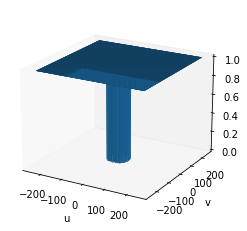

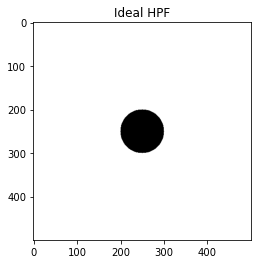

In [9]:
# Plotting the transfer function of LPF's
# Get meshgrid for plotting
U, V = ec_img_utils.dftuv(500,500)

# Ideal HPF filter
H_ideal_hpf = ec_img_utils.hp_filter('ideal', 500, 500, 50)

# shift spectrum
H_ideal_hpf_shft = scipy.fft.fftshift(H_ideal_hpf).astype(int)

fig_hpf_ideal = plt.figure()

ax_hpf_ideal = fig_hpf_ideal.add_subplot(1, 1, 1, projection = '3d')
ideal_surf_hpf = ax_hpf_ideal.plot_surface(U, V, H_ideal_hpf)
ax_hpf_ideal.set_xlabel('u')
ax_hpf_ideal.set_ylabel('v')
ax_hpf_ideal.view_init(20)
ax_hpf_ideal.grid(False)

# Display 2D ideal LPF as an image
fig_hpf_ideal2, ax_hpf_ideal2 = plt.subplots(1, 1)
ax_hpf_ideal2.imshow(H_ideal_hpf_shft, cmap = 'gray'); ax_hpf_ideal2.set_title('Ideal HPF')

From the 3D plot and ideal HPF image shown above, we see that the ideal HPF essentially masks out any frequency components outside its passband denoted by the white pixels in the image above.

Next, we explore a Butterworth filter with a smoother transition relative to our 'brickwall' ideal HPF. A Butterworth filter has the following transfer function:

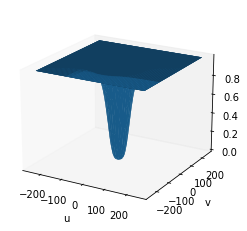

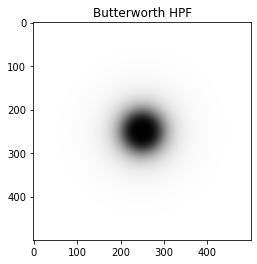

In [10]:
# Butterworth HPF filter
H_butterworth_hpf = ec_img_utils.hp_filter('butterworth', 500, 500, 50, 2)

# shift spectrum
H_butterworth_hpf_shft = scipy.fft.fftshift(H_butterworth_hpf)

fig_hpf_bttr = plt.figure()

ax_hpf_bttr = fig_hpf_bttr.add_subplot(1, 1, 1, projection = '3d')
bttr_surf_hpf = ax_hpf_bttr.plot_surface(U, V, H_butterworth_hpf)
ax_hpf_bttr.set_xlabel('u')
ax_hpf_bttr.set_ylabel('v')
ax_hpf_bttr.view_init(20)
ax_hpf_bttr.grid(False)

# Display 2D ideal LPF as an image
fig_hpf_bttr2, ax_hpf_bttr2 = plt.subplots(1, 1)
ax_hpf_bttr2.imshow(H_butterworth_hpf_shft, cmap = 'gray'); ax_hpf_bttr2.set_title('Butterworth HPF');

From the Butterworth image shown above, we see that the transition from passband to stopband is more gradual.

Next, we take a look at a Guassian HPF.

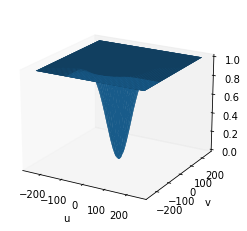

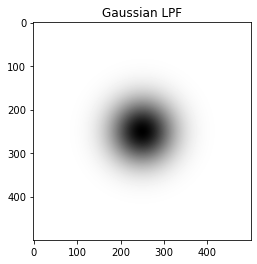

In [11]:
# Butterworth HPF filter
H_gauss_hpf = ec_img_utils.hp_filter('gaussian', 500, 500, 50)

# shift spectrum
H_gauss_shft_hpf = scipy.fft.fftshift(H_gauss_hpf)

fig_hpf_gauss = plt.figure()

ax_hpf_gauss = fig_hpf_gauss.add_subplot(1, 1, 1, projection = '3d')
gauss_surf_hpf = ax_hpf_gauss.plot_surface(U, V, H_gauss_hpf)
ax_hpf_gauss.set_xlabel('u')
ax_hpf_gauss.set_ylabel('v')
ax_hpf_gauss.view_init(20)
ax_hpf_gauss.grid(False)

# Display 2D ideal LPF as an image
fig_lpf_gauss2, ax_lpf_gauss2 = plt.subplots(1, 1)
ax_lpf_gauss2.imshow(H_gauss_shft_hpf, cmap = 'gray'); ax_lpf_gauss2.set_title('Gaussian LPF');

Again, as discussed for the lowpass Gaussian filter case, the stopband transition for a Gaussian filter is wider than
the Butterworth filter plotted above. However, we can control our Butterworth' filter stopband transition by controlling
the filter order.

**Example 4.5 from DIPUM - Highpass filtering, continued**

Text(0.5, 1.0, 'Gaussian HPF Image')

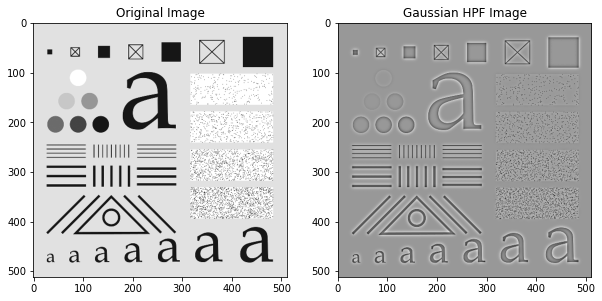

In [12]:
#We're going to be sharpening our test patter image

# Get the padded dimensions again
padded_dim_hpf = ec_img_utils.padded_size({"img_dim": img_tst_pttrn.shape})
#print(padded_dim_hpf)

# Define cutoff frequency
D0 = 50

# Gaussian HPF
hpf_gauss = ec_img_utils.hp_filter('gaussian', padded_dim_hpf[0], padded_dim_hpf[1], D0)

# Filter the image
img_pttrn_hp_gauss = ec_img_utils.dft_filt(img_tst_pttrn, hpf_gauss, 'symmetric')

# Display the image
fig_pttrn_hp, ax_pttrn_hp = plt.subplots(1,2,figsize=(10,5))
ax_pttrn_hp = ax_pttrn_hp.ravel()

ax_pttrn_hp[0].imshow(img_tst_pttrn, cmap='gray')
ax_pttrn_hp[0].set_title('Original Image')

ax_pttrn_hp[1].imshow(img_pttrn_hp_gauss, cmap='gray')
ax_pttrn_hp[1].set_title('Gaussian HPF Image')

As shown in the image above we obtained sharper edges and sharper intensity transitions. However, since highpass filters
zero out the DC term or average intensity from our image, we lost the gray scale tonality. The average intensity of our
highpass filtered image is zero. This implies that some intensity values for this image are negative and were clipped to
zero for display purposes (scaled between [0,1] when displayed).

In [13]:
# Compute average intensity of our filtered image
hpf_img_avg_int = np.mean(img_pttrn_hp_gauss)
print("The average intensity of our highpass filtered image is: ",hpf_img_avg_int)

The average intensity of our highpass filtered image is:  -0.0004819401311571646


**High-frequency Emphasis Filtering**

Modifying highpass filtering to preserve image tonality. We can modify our highpass filter transfer function by adding an
offset to combat a zero average intensity (DC term). When an offset as well as a constant greater than 1 is used to modify
the highpass filter transfer function, we get *high-frequency emphasis filters*.

\begin{equation}
H_{HFE}(u,v) = a + bH_{HP}(u,v)
\end{equation}

Where $a$ is the offset, $b$ is the multiplier, and $H_{HP}(u,v)$ is the transfer function of the highpass filter.

**Example 4.6 from DIPUM - Combining high-frequency emphasis and histogram equalization**

[ 836 1204]
Image Information

 | Shape      | Data type   |       Bytes |     Range |
|------------|-------------|-------------|-----------|
| (418, 602) | float64     | 2.01309e+06 | -0.228729 |
|            |             |             |  1        |


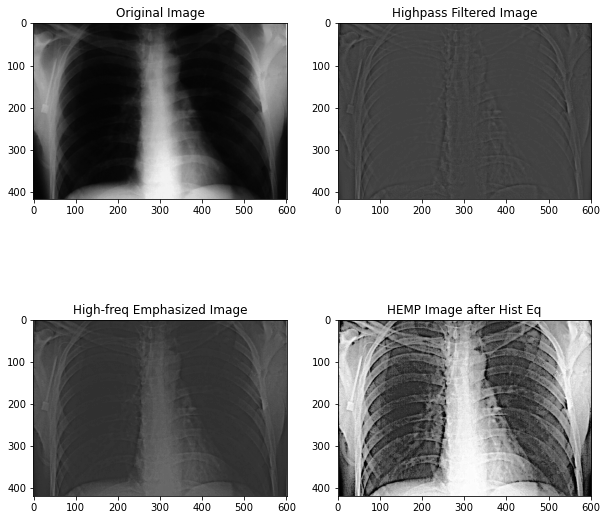

In [14]:
# Load blurry X-ray image
img_xray = io.imread('./images/chestXray-dark.tif')

# Display image
fig_xray, ax_xray = plt.subplots(2,2,figsize=(10,10))
ax_xray = ax_xray.ravel()

ax_xray[0].imshow(img_xray, cmap='gray')
ax_xray[0].set_title('Original Image');

# Get padding dimensions
pad_dim_xray = ec_img_utils.padded_size({"img_dim": img_xray.shape})
print(pad_dim_xray)

# Define cutoff frequency
D0_xray = np.round(0.05*pad_dim_xray[0])
#print(D0_xray)

# Define Butterworth filter
hpf_btt_xray = ec_img_utils.hp_filter('butterworth',pad_dim_xray[1],pad_dim_xray[0],D0_xray,2)

# Filter image
xray_hp_flt = ec_img_utils.dft_filt(img_xray, hpf_btt_xray, 'symmetric')

# Display filtered image

ax_xray[1].imshow(xray_hp_flt, cmap='gray')
ax_xray[1].set_title('Highpass Filtered Image');

# Implement high-frequency emphasis filtering
hpf_hemp = 0.5 + 2.0*hpf_btt_xray

# Filter the image again
xray_hemp = ec_img_utils.dft_filt(img_xray, hpf_hemp, 'symmetric')

# Display the resulting image
ax_xray[2].imshow(xray_hemp, cmap='gray')
ax_xray[2].set_title('High-freq Emphasized Image');

# Print intensity range of the image before histogram equalization
ec_img_utils.get_img_info(xray_hemp/np.max(xray_hemp))

# Perform histogram equalization to enhance the gray tonality
img_xray_histeq = skimage.exposure.equalize_hist(xray_hemp)

# Display histogram equalized image
ax_xray[3].imshow(img_xray_histeq, cmap='gray')
ax_xray[3].set_title('HEMP Image after Hist Eq');

As shown in the example above, high-frequency emphasis filtering produced better sharpening results than highpass filtering
alone. However, the resulting image's intensity range was still contrived to a small range inside the full [-1,1] possible
range for an image with a signed float type. Histogram equalization helped us enhance the intensity range. The resulting
image shows sharper and brighter details than the original. Lastly, the resulting image appears a little noisy, but Gonzalez
et al. claim that this is typical for X-ray images.

### Bandreject, Bandpass, Notchreject, and Notchpass Filtering

Bandreject and bandpass filters are useful for selecting specific frequencies within the frequency rectangle.

The plots below will show typical bandreject filter transfer functions

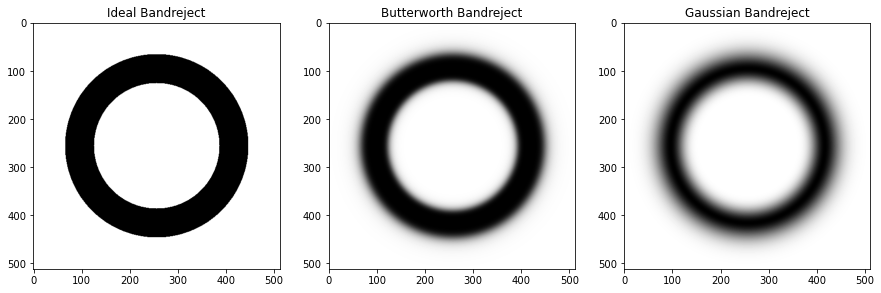

In [24]:
# Define bandreject filter parameters

# filter dimensions
M = 512
N = 512

U, V = ec_img_utils.dftuv(M, N)

# center frequency
C0 = 160

# reject band width
W = 60

# ideal bandreject filter
ideal_params = {'M': M, 'N': N, 'C0': C0, 'W': W, 'type': 'ideal', 'bandpass_flag': False}
ideal_bndrej = scipy.fft.fftshift(ec_img_utils.bandfilter(ideal_params))

# butterworth
bttr_params = {'M': M, 'N': N, 'C0': C0, 'W': W, 'n': 3, 'type': 'butterworth', 'bandpass_flag': False}
bttr_reject = scipy.fft.fftshift(ec_img_utils.bandfilter(bttr_params))

# gaussian
gauss_params = {'M': M, 'N': N, 'C0': C0, 'W': W, 'type': 'gaussian', 'bandpass_flag': False}
gaussian_reject = scipy.fft.fftshift(ec_img_utils.bandfilter(gauss_params))

# Display 2D ideal bandreject as an image
fig_bnd_rej, ax_bnd_rej = plt.subplots(1, 3, figsize=(15,5))
ax_bnd_rej = ax_bnd_rej.ravel()

ax_bnd_rej[0].imshow(ideal_bndrej, cmap = 'gray'); ax_bnd_rej[0].set_title('Ideal Bandreject');
ax_bnd_rej[1].imshow(bttr_reject, cmap = 'gray'); ax_bnd_rej[1].set_title('Butterworth Bandreject');
ax_bnd_rej[2].imshow(gaussian_reject, cmap = 'gray'); ax_bnd_rej[2].set_title('Gaussian Bandreject');

As shown from the bandreject filter transfer functions plotted above, the passband of our filter are the frequencies
outlined in white. Anything that falls within the black rings will be rejected by the bandreject filters. Note how the
Butterworth filter specified above falls somewhere in between the ideal bandreject and the Gaussian filter. Of course,
the transition bands for both the Butterworth and the Gaussian filters can be controlled by their respective parameters.

**Example 4.7 from DIPUM - Lowpass, highpass, and band filtering**